In [4]:
# !pip install pytube

In [1]:
from datasets.youtube_data import download_n_preprocess_youtube_video
from datasets.youtube_data import YoutubeVideoDataset

# Download new videos
url = 'https://www.youtube.com/watch?v=oMzc_OJqaF8'
vid_name = 'kyoto_drive_360p'
save_dir = 'D:/Implementation/VD/data/drive'
# download_n_preprocess_youtube_video(url, vid_name, save_dir)

# Just load the dataset
ydata = YoutubeVideoDataset(save_dir, frames_per_sample=4)

,,,

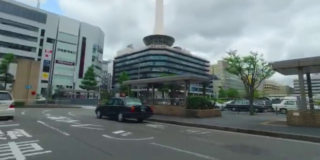
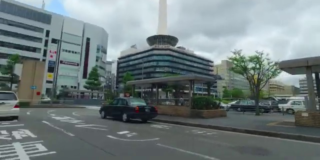
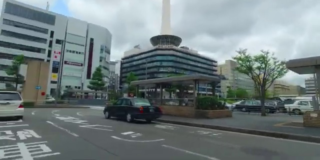
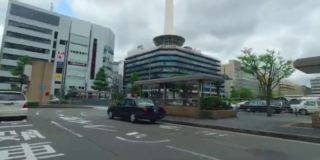

In [2]:
import mediapy as media
media.show_images(ydata[939][0].permute(0,2,3,1), height=700)

In [4]:
# Load Trained Checkpoint here 
print('Loading Trained Checkpoint')
import sys
import glob, os
import mediapy as media
import torch
from torch.utils.data import DataLoader

from load_model_from_ckpt import load_model, get_sampler, init_samples
from datasets import get_dataset, data_transform, inverse_data_transform
from runners.ncsn_runner import conditioning_fn

# from os.path import expanduser
# home = expanduser("~")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
EXP_PATH = 'D:/Implementation/VD/mcvd-pytorch/youtube_drive/'
ckpt_path = glob.glob(os.path.join(EXP_PATH, 'logs/checkpoint*.pt'))[0]
scorenet, config = load_model(ckpt_path, device)
sampler = get_sampler(config)

Loading Trained Checkpoint


In [5]:
# We can for instance load out dataset and the model and see if they successfully propagate towards each other
DATA_PATH = 'D:/Implementation/VD/data/drive'
# DATA_PATH = os.path.join(home, "scratch\Datasets\MNIST")
# config.data.dataset='YOUTUBEVIDEO'
# config.data.channels=3
# config.data.dataset='StochasticMovingMNIST'
dataset, test_dataset = get_dataset(DATA_PATH, config, video_frames_pred=config.data.num_frames)

In [6]:
test_loader = DataLoader(test_dataset, batch_size=config.training.batch_size, shuffle=False,
                         num_workers=config.data.num_workers, drop_last=True)
test_iter = iter(test_loader)
test_x, test_y = next(test_iter)
# print(test_x.shape)

test_x = data_transform(config, test_x) # shape is fine here
real, cond, cond_mask = conditioning_fn(config, test_x, num_frames_pred=config.data.num_frames,
                                        prob_mask_cond=getattr(config.data, 'prob_mask_cond', 0.0),
                                        prob_mask_future=getattr(config.data, 'prob_mask_future', 0.0))
init = init_samples(len(real), config)

In [9]:
conditioning_fn

<function runners.ncsn_runner.conditioning_fn(config, X, num_frames_pred=0, prob_mask_cond=0.0, prob_mask_future=0.0, conditional=True)>

In [7]:
init.shape, cond.shape

(torch.Size([8, 6, 160, 320]), torch.Size([8, 12, 160, 160]))

In [8]:
pred = sampler(init, scorenet, cond=cond, cond_mask=cond_mask, subsample=100, verbose=True)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 320 but got size 160 for tensor number 1 in the list.

,,,

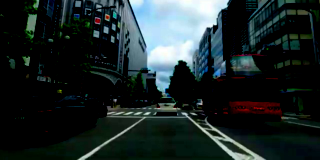
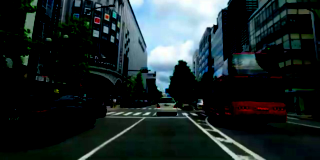
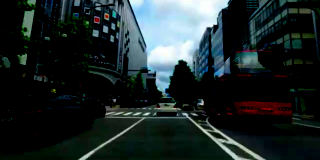
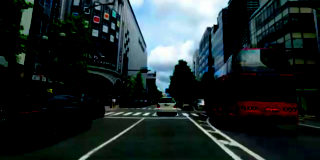

,,,

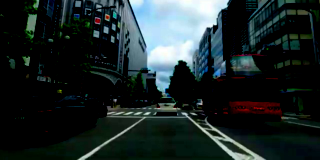
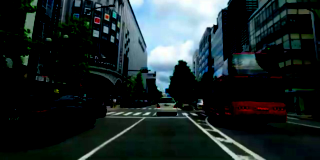
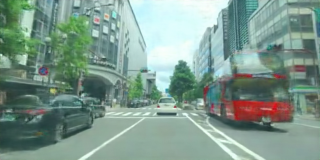
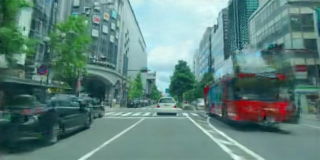

In [11]:
i = 2
cond_vis, real_vis = cond[i].view(config.data.num_frames_cond, config.data.channels, config.data.image_height, config.data.image_width), real[i].view(config.data.num_frames, config.data.channels, config.data.image_height, config.data.image_width)
pred_vis = pred[i].view(config.data.num_frames, config.data.channels, config.data.image_height, config.data.image_width)
# media.show_images(torch.cat([cond_vis, real_vis]).permute(0,2,3,1))
media.show_images(torch.cat([cond_vis, real_vis]).permute(0,2,3,1))

media.show_images(torch.cat([cond_vis, pred_vis]).permute(0,2,3,1))

In [1]:
# Tha main function sotre the args, config in .yml files, we can reverse the process and obtain args, config 
# To replace the parse_args_and_config() functional, which do not work under jupyter lab, only under terminal command line
# Import the yaml module

import yaml
import os
import torch

log_path = './youtube_drive/logs'
# Open the YAML file that contains the config data
with open(os.path.join(log_path, 'config.yml'), "r") as f:
    # Load the YAML data as a Python dictionary
    config_dict = yaml.load(f, Loader=yaml.FullLoader)
# Open the YAML file that contains the args data
with open(os.path.join(log_path, 'args.yml'), "r") as f:
    # Load the YAML data as a Python dictionary
    args_dict = yaml.load(f, Loader=yaml.FullLoader)


from main import dict2namespace

args = dict2namespace(args_dict)
config = dict2namespace(config_dict)
config_uncond = dict2namespace(config_dict)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
config.device = device
config_uncond.device = device
# Try propagate inside a NCSNRunner: Successful connection ! 
from runners import *
runner = NCSNRunner(args, config, config_uncond)

# Debug on the runner, enable training with youtube video dataset here ! 
# runner.train() # The Issue is NCSN model assumes squared image with H=W, but we need to extend it to variable Height and Width here ! 

In [2]:
runner.config.sampling.data_init
runner.args.image_folder

'D:/Implementation/VD/mcvd-pytorch/images'

In [3]:
args

Namespace(ckpt=None, command='python main.py --config configs/youtube_drive.yml --data_path D:/Implementation/VD/data/drive --exp youtube_drive --ni', comment='', config='configs/youtube_drive.yml', config_mod=[], data_path='D:/Implementation/VD/data/drive', end_ckpt=None, exp='youtube_drive', fast_fid=False, feats_dir='D:/Implementation/VD/mcvd-pytorch/datasets', fid_batch_size=1000, fid_num_samples=None, final_only=None, freq=None, image_folder='D:/Implementation/VD/mcvd-pytorch/images', interact=False, log_path='youtube_drive\\logs', log_sample_path='youtube_drive\\logs\\samples', ni=True, no_ema=False, no_pr=False, pr_nn_k=None, resume_training=False, sample=False, seed=1234, start_at=0, stats_dir='D:/Implementation/VD/mcvd-pytorch/datasets', stats_download=False, subsample=None, test=False, verbose='info', video_folder='D:/Implementation/VD/mcvd-pytorch/videos', video_gen=False)

In [3]:
runner.config.sampling.data_init

False

In [2]:
# runner.video_gen()
runner.sample() # init samples should be pure noise | cond is the conditional frame | all samples are the recontructed frames

DBG: init_samples shape:  torch.Size([25, 6, 160, 320])  || cond shape:  torch.Size([25, 6, 160, 320])
DDPM: 1/100, grad_norm: 553.9921875, image_norm: 501.133544921875, grad_mean_norm: 12264.775390625
DDPM: 10/100, grad_norm: 554.3584594726562, image_norm: 505.88397216796875, grad_mean_norm: 12286.017578125
DDPM: 20/100, grad_norm: 554.6718139648438, image_norm: 510.659912109375, grad_mean_norm: 12338.912109375
DDPM: 30/100, grad_norm: 556.8406372070312, image_norm: 514.5234375, grad_mean_norm: 12327.302734375
DDPM: 40/100, grad_norm: 561.69873046875, image_norm: 516.0469970703125, grad_mean_norm: 12387.3447265625
DDPM: 50/100, grad_norm: 574.8562622070312, image_norm: 509.667724609375, grad_mean_norm: 12282.828125
DDPM: 60/100, grad_norm: 611.3473510742188, image_norm: 488.1507263183594, grad_mean_norm: 12212.58984375
DDPM: 70/100, grad_norm: 698.203125, image_norm: 443.4435729980469, grad_mean_norm: 12209.3583984375
DDPM: 80/100, grad_norm: 910.958740234375, image_norm: 373.47375488

In [16]:
init_samples.shape, cond.shape, all_samples.shape

(torch.Size([25, 6, 160, 320]),
 torch.Size([25, 6, 160, 320]),
 torch.Size([1, 25, 6, 160, 320]))

Initial Samples -- Pure Noise


,

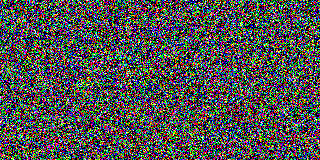
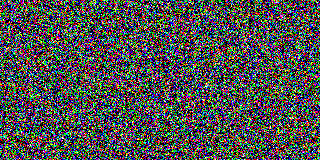

Conditional Samples -- Previous Frames


,

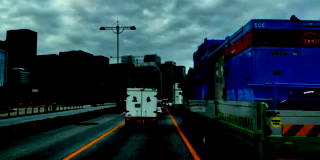
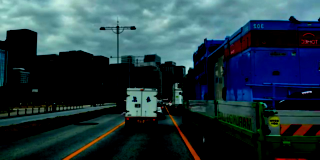

Denoised Prediction Frames


,

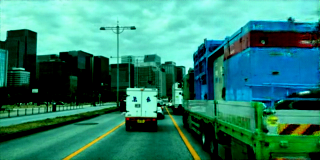
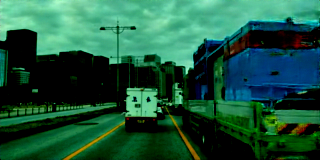

In [17]:
import mediapy as media
print('Initial Samples -- Pure Noise')
media.show_images(init_samples[0].cpu().reshape(-1, config.data.channels, config.data.image_height, config.data.image_width).permute(0,2,3,1))
print('Conditional Samples -- Previous Frames')
media.show_images(cond[0].cpu().reshape(-1, config.data.channels, config.data.image_height, config.data.image_width).permute(0,2,3,1))
print('Denoised Prediction Frames')
media.show_images(all_samples[0][0].cpu().reshape(-1, config.data.channels, config.data.image_height, config.data.image_width).permute(0,2,3,1))

In [12]:
cond.shape

torch.Size([25, 6, 160, 320])

In [3]:
def stretch_image(X, ch, imh, imw): # (B, NC, H, W) -> (B, C, H, NW)
    return X.reshape(len(X), -1, ch, imh, imw).permute(0, 2, 1, 4, 3).reshape(len(X), ch, -1, imh).permute(0, 1, 3, 2)

In [4]:
from datasets import get_dataset, data_transform, inverse_data_transform
import tqdm
from tqdm import tqdm as tqdm

for i, sample in tqdm(enumerate(all_samples), total=len(all_samples),
                                               desc="saving image samples"):
    
    sample =  sample.reshape(runner.config.sampling.batch_size, 
                   runner.config.data.num_frames, 
                   runner.config.data.channels, 
                   runner.config.data.image_height, 
                   runner.config.data.image_width)
    
    sample = inverse_data_transform(runner.config, sample)
    continue
    # Stretch out multiple frames horizontally
    sample = stretch_image(sample, runner.config.data.channels, runner.config.data.image_size)

    nrow = ceil(np.sqrt(runner.config.data.num_frames*runner.config.sampling.batch_size)/runner.config.data.num_frames)
    image_grid = make_grid(sample, nrow, pad_value=0.5)

saving image samples: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.43it/s]


In [16]:
all_samples.shape

torch.Size([1, 25, 6, 160, 320])

In [5]:
sample.shape

torch.Size([25, 2, 3, 160, 320])

""

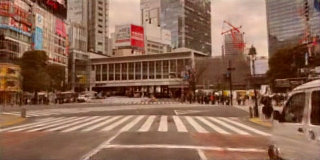

In [15]:
import mediapy as media
media.show_image(sample[4,0].permute(1,2,0))

In [28]:
X = sample
ch, imh, imw = runner.config.data.channels, runner.config.data.image_height, runner.config.data.image_width

X.reshape(len(X), -1, ch, imh, imw).permute(0, 2, 1, 4, 3).reshape(len(X), ch, -1, imh).permute(0, 1, 3, 2)

torch.Size([25, 3, 160, 640])

In [16]:
runner.config.test.batch_size
runner.config.sampling.batch_size

25

In [7]:
from runners.ncsn_runner import get_model, get_optimizer, anneal_dsm_score_estimation, get_dataset
from torch.utils.data import DataLoader

# Issue is inside the train section of the NCSNRunner object -- we breakdown the NCSNRunner object and see where the issue is
scorenet = get_model(config) # model
optimizer = get_optimizer(config, scorenet.parameters()) # optimizer
# dataset & dataloader
dataset, test_dataset = get_dataset(args.data_path, config, video_frames_pred=config.data.num_frames, start_at=args.start_at)
dataloader = DataLoader(dataset, batch_size=config.training.batch_size, shuffle=True, num_workers=config.data.num_workers)

# values
conditional = config.data.num_frames_cond > 0
# Issue is in the confitioning functional
for batch, (X, y) in enumerate(dataloader):
    optimizer.zero_grad()
    # lr = warmup_lr(optimizer, step, getattr(self.config.optim, 'warmup', 0), self.config.optim.lr)
    scorenet.train()
    # Data
    X = X.to(config.device)
    X = data_transform(config, X) # The issue is with the data_transform functional -- it needs to resize on the image here !! 
    print('Pre-conditioning fn X shape: ', X.shape)
    X, cond, cond_mask = conditioning_fn(config, X, num_frames_pred=config.data.num_frames,
                                         prob_mask_cond=getattr(config.data, 'prob_mask_cond', 0.0),
                                         prob_mask_future=getattr(config.data, 'prob_mask_future', 0.0),
                                         conditional=conditional)
    print('Pass Conditioning Functional Noisy Future Frames shape: ', X.shape, ' Conditional Past Frames Shape: ', cond.shape)
    hook = None
    # Second Issue inside the loss computation function here
    print('Start Computing Loss functional --')
    loss = anneal_dsm_score_estimation(scorenet, X, labels=None, cond=cond, cond_mask=cond_mask,
                                                   loss_type=getattr(config.training, 'loss_type', 'a'),
                                                   gamma=getattr(config.model, 'gamma', False),
                                                   L1=getattr(config.training, 'L1', False), hook=hook,
                                                   all_frames=getattr(config.model, 'output_all_frames', False))
    print('Loss Computation Complete')
    break

Pre-conditioning fn X shape:  torch.Size([8, 4, 3, 160, 320])
Pass Conditioning Functional Noisy Future Frames shape:  torch.Size([8, 6, 160, 320])  Conditional Past Frames Shape:  torch.Size([8, 6, 160, 320])
Start Computing Loss functional --
Loss Computation Complete


In [7]:
from functools import partial

x = X
net = scorenet.module if hasattr(scorenet, 'module') else scorenet
version = getattr(net, 'version', 'SMLD').upper() # getattr works on the Namespace object, with the default value specified in the last argument
net_type = getattr(net, 'type') if isinstance(getattr(net, 'type'), str) else 'v1'

labels=None
cond=cond
cond_mask=cond_mask
loss_type=getattr(config.training, 'loss_type', 'a')
gamma=getattr(config.model, 'gamma', False)
L1=getattr(config.training, 'L1', False)
hook=hook
all_frames=getattr(config.model, 'output_all_frames', False)

version, all_frames, labels, gamma

alphas = net.alphas
if labels is None:
    labels = torch.randint(0, len(alphas), (x.shape[0],), device=x.device)
used_alphas = alphas[labels].reshape(x.shape[0], *([1] * len(x.shape[1:])))

z = torch.randn_like(x)

perturbed_x = used_alphas.sqrt() * x + (1 - used_alphas).sqrt() * z
scorenetpp = partial(scorenet, cond=cond)

# Loss
if L1:
    def pow_(x):
        return x.abs()
else:
    def pow_(x):
        return 1 / 2. * x.square()
# Issue is with the propagation of the scorenet object
loss = pow_((z - scorenetpp(perturbed_x, labels, cond_mask=cond_mask)).reshape(len(x), -1)).sum(dim=-1)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 44 but got size 45 for tensor number 1 in the list.

In [10]:
perturbed_x.shape, labels.shape, x.shape

(torch.Size([8, 6, 180, 320]), torch.Size([8]), torch.Size([8, 6, 180, 320]))

In [ ]:
# python main.py --config configs/youtube_drive.yml --data_path D:/Implementation/VD/data/drive --exp youtube_drive --ni

python experiment.py --config configs/youtube_drive.yml --data_path D:/Implementation/VD/data/drive --exp youtube_drive --ni